In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datasets import *
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
from random import randint
import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate
from keras.layers import Input, Reshape, Dense, Conv2D, Dropout, \
    MaxPooling2D, Flatten, UpSampling2D, Multiply, Activation, AveragePooling2D, \
    Add, Subtract, Lambda
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard
from scipy.ndimage import gaussian_filter as blur
from keras.optimizers import Adam
from keras.utils import multi_gpu_model as mgpu
from keras.utils import np_utils
import os, sys

Using TensorFlow backend.


In [2]:
from models.gap import gap

model = gap(imsize=256)

 [!] Conv Spec:
 [!] 256 => 128: [64, 128]
 [!] 128 => 64: [256, 256, 256, 256]
 [!] 64 => 32: [256, 256, 256, 256]
 [!] 32 => 16: [512, 512, 512, 512]
 [!] 16 => 8: [512, 512, 512, 512]
 [!] 8 => 8: [512, 512, 512, 512]
 [!] 8 => 8: [1024, 1024, 2048, 2048]


In [3]:
print(model.count_params())
model.compile()
model.load()

102.5 million


In [4]:
dset = Tissue()

 [*] tissue_sick: 2118 unique cases
 [*] tissue_healthy: 2951 unique cases
 [*] tissue_sick: 1606 / 512
 [*] tissue_healthy: 229652 / 48912


In [18]:
bsize=24
evalgen = dset.gen(bsize=bsize, labels=['masks', 'lbls', 'refs'], mode='test')

In [33]:
imgs, masks, lbls, refs = next(evalgen)

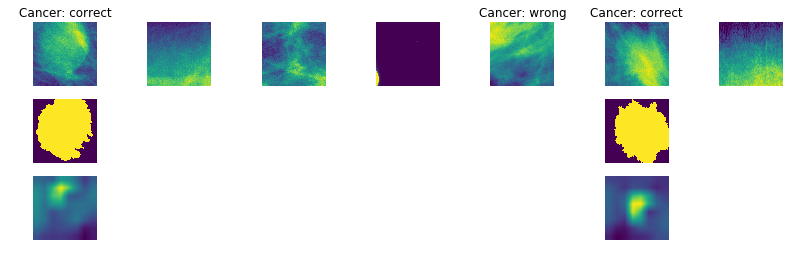

In [41]:

ypreds = model.model.predict(imgs)
fmaps, _ = model.saliency(imgs)
weights = model.core.layers[-2].get_weights()[0][:, 1] # weights for 1 output

plt.figure(figsize=(14, 4))
for ii in range(7): # preview 7 images
    plt.subplot(3, 7, ii+1)
    if np.argmax(ypreds[ii]) == 1: # detected:
        plt.gca().set_title('Cancer: %s' % ('correct' if np.argmax(lbls[ii]) == 1 else 'wrong'))
    elif np.argmax(ypreds[ii]) == 0 and np.argmax(lbls[ii]) == 1: # detected:
        plt.gca().set_title('FN')
    else:
        pass

    plt.axis('off')
    plt.imshow(imgs[ii, :, :, 0])
    
    
    if np.argmax(lbls[ii]) == 1:
        plt.subplot(3, 7, 7+ii+1)
        plt.axis('off')
        plt.imshow(masks[ii, :, :, 0], vmin=0, vmax=1)
        
        plt.subplot(3, 7, 14+ii+1)
        plt.axis('off')
        A = np.zeros((8, 8))
        for jj in range(2048):
            A += fmaps[ii, :, :, jj] * weights[jj]
        A -= np.min(A)
        A /= np.max(A)
        A = cv2.resize(A, (0,0), fx=32, fy=32)
        plt.imshow(A, vmin=0, vmax=1)
plt.show()
plt.close()

In [64]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

bsize=24
evalgen = dset.gen(bsize=bsize, labels=['masks', 'lbls', 'refs'], mode='test')
    
results = []
for trial in range(5):
    labels = []
    preds = []    
    correct = 0
    total = 0
    
    iters = dset.test_size // bsize
    for ii in range(iters):
        imgs, masks, lbls, refs = next(evalgen)
        total += len(imgs)

        ys = model.model.predict(imgs)
        labels += [ent[1] for ent in lbls.tolist()]
        preds += [ent[1] for ent in ys.tolist()]

        for lii, pr in enumerate(ys):
            if np.argmax(pr) == np.argmax(lbls[lii]): correct += 1
        sys.stdout.write('%d - %d/%d         \r' % (trial, ii, iters))
        sys.stdout.flush()
    results.append([labels, preds])

#     print(correct, total)

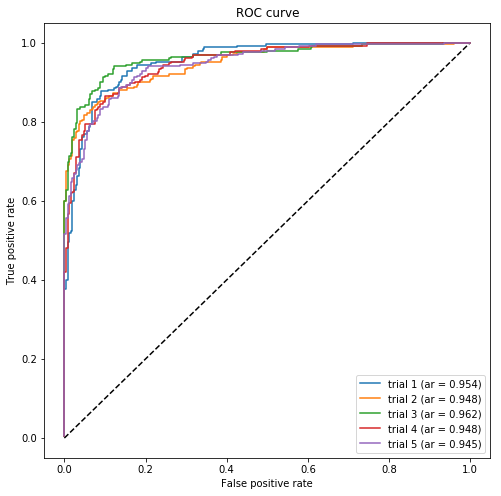

In [66]:

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
for ii, (ll, pp) in enumerate(results):
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(ll, pp)
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.plot(fpr_keras, tpr_keras, label='trial {:d} (ar = {:.3f})'.format(ii+1, auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()
# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()